## BERT embedding and final results 

I trained a classification NN here after BERT embeddings. BERT, based on transformers, is very computationally intensive. I will use a subset of my dataset for training, this will of course reduce the performance but it is the limit of my computer resources.  

In [1]:
%load_ext autoreload
%autoreload 2
from  tm_common import *
IN_COLAB, output_dir = tm_get_working_config()
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
import tensorflow_text
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Flatten,
    Embedding,
    Dense,
    Input,
    Embedding,
    GlobalAveragePooling1D,
)

c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\dev\topic_modelling\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword arg

In [2]:
# load train test sets
X_train, X_test, y_train, y_test    = tm_load_train_test_set(output_dir)
X_corpus_train, X_corpus_test       = tm_load_train_test_set(output_dir, option="raw_corpus")
# # only take a subset to fasten computation 
for i in range(2):
    X_corpus_train, y_train       = tm_get_subset(X_corpus_train, y_train)
    X_corpus_test, y_test       = tm_get_subset(X_corpus_test, y_test)
label_list = tm_get_label_list(output_dir)

In [3]:
y_train_b, y_test_b = tm_multilabel_binarizer(y_train, y_test)

In [4]:
print( len(X_corpus_train) )
print( len(y_test_b)       )

1545
386


In [5]:
# Load BERT and the preprocessing model from TF Hub.
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1')
encoder = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3')

In [6]:
X_train_bert_preproc = preprocess(X_corpus_train)


In [7]:
X_train_bert_preproc.keys()

dict_keys(['input_mask', 'input_type_ids', 'input_word_ids'])

In [8]:
X_train_bert_emb = encoder(X_train_bert_preproc)['pooled_output']

In [9]:
del X_train_bert_preproc

In [10]:
X_test_bert_preproc = preprocess(X_corpus_test)
X_test_bert_emb = encoder(X_test_bert_preproc)['pooled_output']

In [11]:
del X_test_bert_preproc

In [12]:
bert_model = Sequential()
bert_model.add(Dense(256, activation='relu', input_dim=768))
bert_model.add(Dense(128, activation='relu'))
bert_model.add(Dense(30,activation='sigmoid'))
bert_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
bert_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 30)                3870      
                                                                 
Total params: 233,630
Trainable params: 233,630
Non-trainable params: 0
_________________________________________________________________


In [13]:
bert_model.fit(X_train_bert_emb, y_train_b, batch_size = 128, epochs=100)

Epoch 1/100
13/13 [==============================] - 1s 3ms/step - loss: 0.3862 - accuracy: 0.0718
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.2222 - accuracy: 0.1353
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1980 - accuracy: 0.1476
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1956 - accuracy: 0.1547
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1934 - accuracy: 0.1592
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1927 - accuracy: 0.1786
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1921 - accuracy: 0.1909
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1917 - accuracy: 0.1612
Epoch 9/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1909 - accuracy: 0.1851
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.1900 - accuracy: 0.1903
Epoch 11/

4/4 [==============================] - 0s 2ms/step


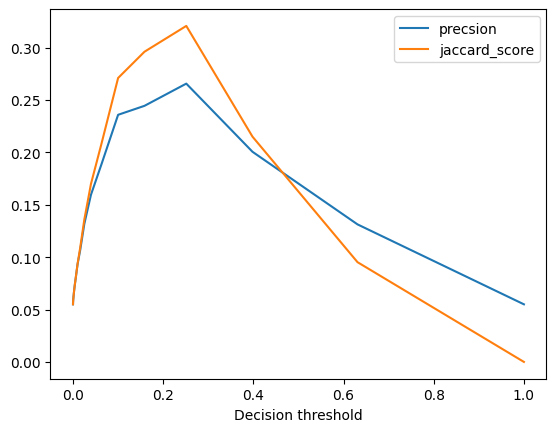

In [14]:
y_pred = bert_model.predict(X_train_bert_emb[:100])
threshold_test_use = tm_test_threshold(y_train_b[:100], y_pred)  
tm_plot_threshold_test(threshold_test_use)

In [15]:
max_config = threshold_test_use.query('precision == precision.max()')
t = max_config["threshold"]
best_t =  t.values[0]
best_t

0.25118864315094075

In [16]:
y_pred_bert = bert_model.predict(X_test_bert_emb)
y_pred_bert = (y_pred_bert > best_t).astype(np.float32)
precision_bert      = average_precision_score(y_test_b, y_pred_bert, average='micro')
jaccard_score_bert = jaccard_score(y_test_b, y_pred_bert, average='micro')


13/13 [==============================] - 0s 2ms/step


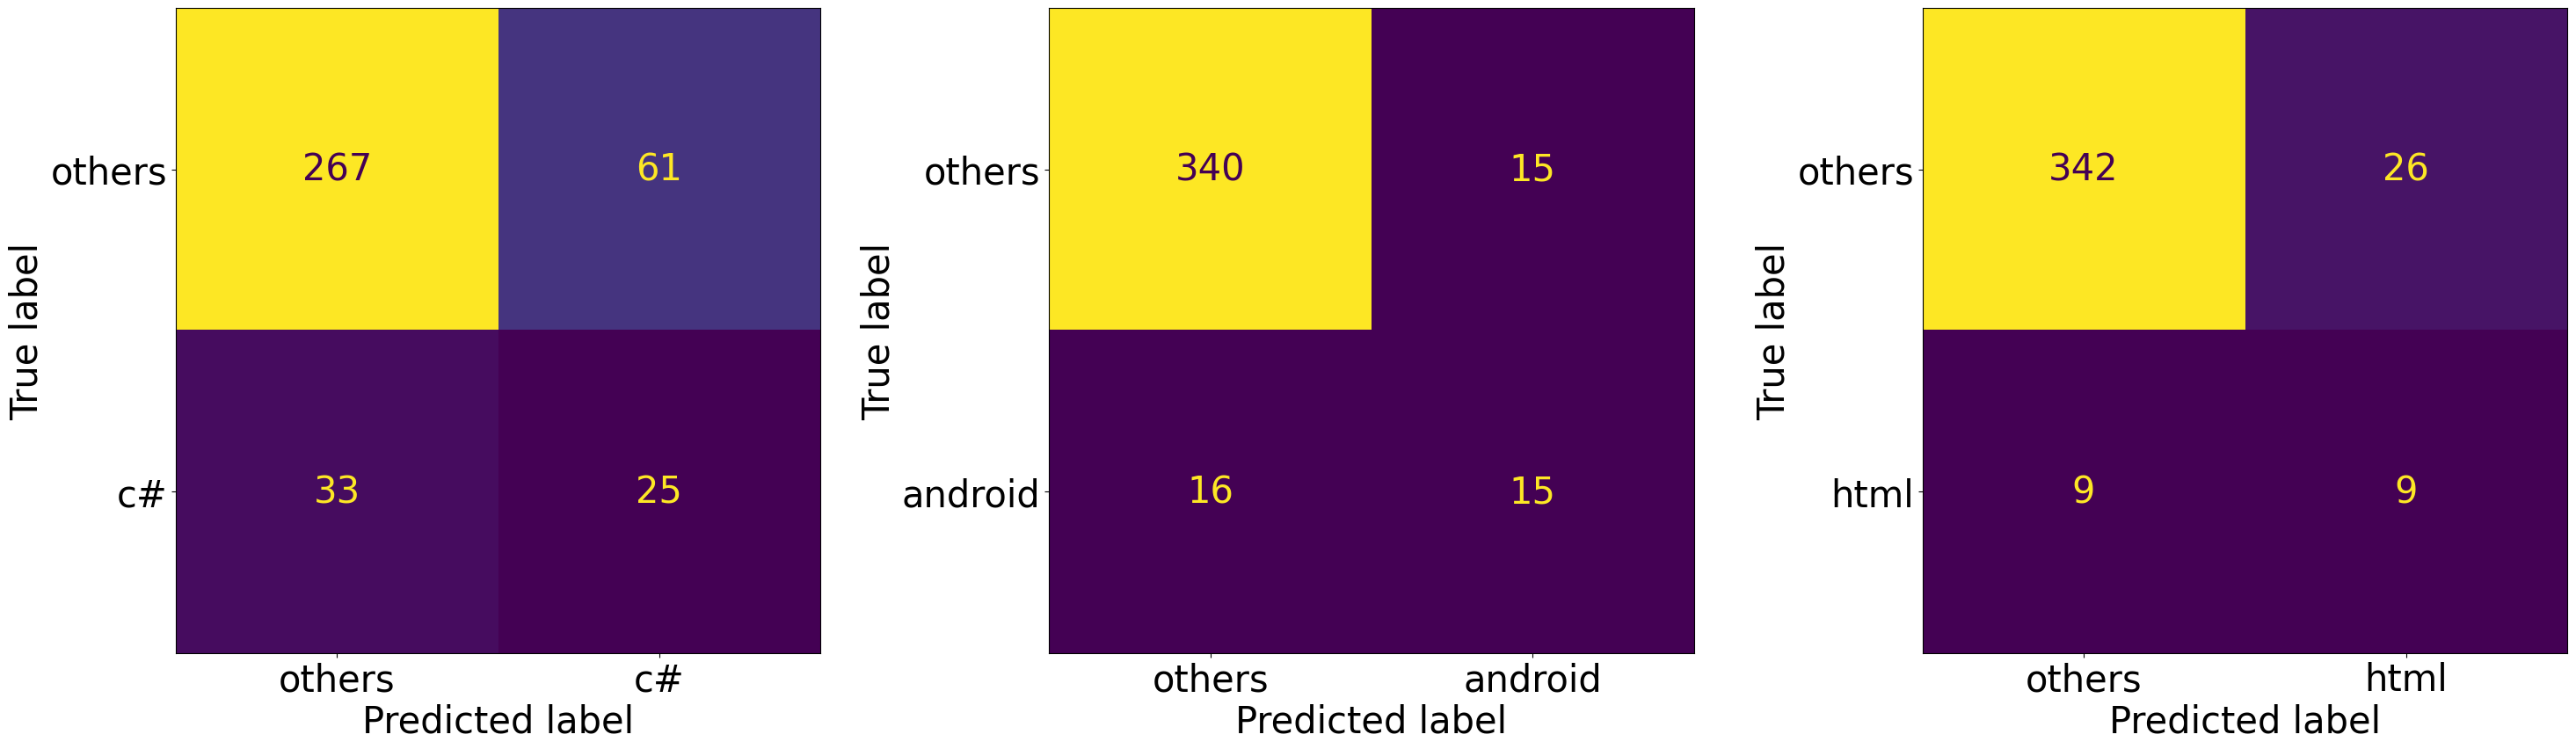

In [21]:
plot_confusion_matrix(y_test_b, y_pred_bert, label_list)

In [26]:
print(classification_report(y_test_b, y_pred_bert, target_names=label_list, digits=2))

                precision    recall  f1-score   support

            c#       0.29      0.43      0.35        58
          java       0.48      0.37      0.42        68
           c++       0.37      0.65      0.47        48
    javascript       0.35      0.64      0.45        45
        python       0.66      0.46      0.54        50
       android       0.50      0.48      0.49        31
           ios       0.53      0.26      0.35        35
          .net       0.00      0.00      0.00        29
           php       0.60      0.33      0.43        18
             c       0.25      0.18      0.21        22
          html       0.26      0.50      0.34        18
        jquery       0.29      0.31      0.30        16
   performance       0.00      0.00      0.00        16
           css       0.40      0.12      0.19        16
   objective-c       0.00      0.00      0.00        12
         c++11       0.29      0.17      0.21        12
       asp.net       0.00      0.00      0.00  

Here, the support is clearly below the one I used for other algorithm.  It explains the lack of precision for very under-represented classes in the test set. 

In [22]:
avg_precision_scores = [precision_bert]
jaccard_scores = [jaccard_score_bert]
result = pd.DataFrame(
    {
        'average_precision_scores' : avg_precision_scores,
        'jaccard_scores' : jaccard_scores
    }, index = ['BERT']
)
result.to_csv(f"{output_dir}result_supervised3.csv")

In [23]:
result1 = pd.read_csv(f"{output_dir}/supervised_1_results.csv")
result2 = pd.read_csv(f"{output_dir}/result_supervised2.csv")
result3 = pd.read_csv(f"{output_dir}/result_supervised3.csv")

# Results

USE embedding is the one achieving the best precision. The SVM algorithm also achieve close performances.  This algorithm  is computationally  less intensive. This could be a good trade off worth taking into consideration. For further work, it would be interesting to train these models on larger dataset especially BERT one. 

In [24]:
supervised_restult = pd.concat([result1, result2,result3], axis=0)
supervised_restult.rename(columns={'Unnamed: 0' : 'model'})

,model,average_precision_scores,jaccard_scores
0,Dummy classifier,0.053830,0.000000
1,logistic : concatenation,0.196039,0.170827
2,SVM : concatenation,0.422422,0.434641
3,RandomForest,0.321323,0.372925
0,Word2Vec,0.085256,0.112318
1,USE,0.463946,0.500000
0,BERT,0.150803,0.201717
